### Solving an Image Classification Problem using PyTorch

In [61]:
from keras.datasets import fashion_mnist

In [62]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

In [63]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### Visualizing the Images

In [64]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
# from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

(<Axes: >, <matplotlib.image.AxesImage at 0x2a8d6e04700>)

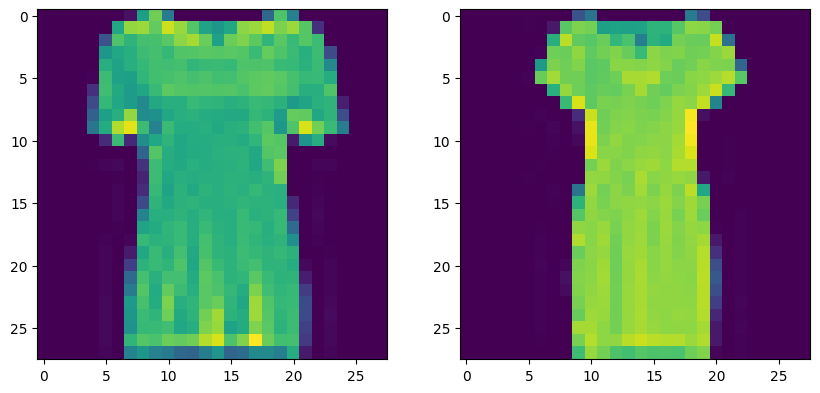

In [65]:
import matplotlib.pyplot as plt

# visualizing images
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(trainX[10])
plt.subplot(222), plt.imshow(trainX[20])
#plt.subplot(223), plt.imshow(trainX[i+50], cmap='gray')
#plt.subplot(224), plt.imshow(trainX[i+75], cmap='gray')

### Create validation set and preprocessing the images 

In [66]:
train_x, val_x, train_y, val_y = train_test_split(trainX, trainY, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((54000, 28, 28), (54000,)), ((6000, 28, 28), (6000,)))

In [67]:
# converting training images into torch format
train_x = train_x.reshape(54000, 1, 28, 28)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([54000, 1, 28, 28]), torch.Size([54000]))

In [68]:
# converting validation images into torch format
val_x = val_x.reshape(6000, 1, 28, 28)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([6000, 1, 28, 28]), torch.Size([6000]))

### CNN Model

In [69]:
## Architecture

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=2, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=2, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

#### Let's now call the model, and define the optimizer and the loss function for the model 

In [70]:
# define the model
model = Net()
# define the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [71]:
## function to train the model

def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    x_train = x_train.float()
    x_val = x_val.float()
    output_train = model(x_train)
    output_val = model(x_val)

    # Ensure that target tensors are of type torch.LongTensor
    y_train = y_train.long()
    y_val = y_val.long()

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    #if epoch%2 == 0:
        # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [72]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(2.6310, grad_fn=<NllLossBackward0>)
Epoch :  2 	 loss : tensor(6.2468, grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(3.8711, grad_fn=<NllLossBackward0>)
Epoch :  4 	 loss : tensor(2.5457, grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(2.0254, grad_fn=<NllLossBackward0>)
Epoch :  6 	 loss : tensor(1.9471, grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(1.8314, grad_fn=<NllLossBackward0>)
Epoch :  8 	 loss : tensor(1.6798, grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(1.6356, grad_fn=<NllLossBackward0>)
Epoch :  10 	 loss : tensor(1.5952, grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(1.5379, grad_fn=<NllLossBackward0>)
Epoch :  12 	 loss : tensor(1.4467, grad_fn=<NllLossBackward0>)
Epoch :  13 	 loss : tensor(1.4107, grad_fn=<NllLossBackward0>)
Epoch :  14 	 loss : tensor(1.3757, grad_fn=<NllLossBackward0>)
Epoch :  15 	 loss : tensor(1.3217, grad_fn=<NllLossBackward0>)
Epoch :  16 	 loss : tensor(1.2697, grad_fn=<NllL

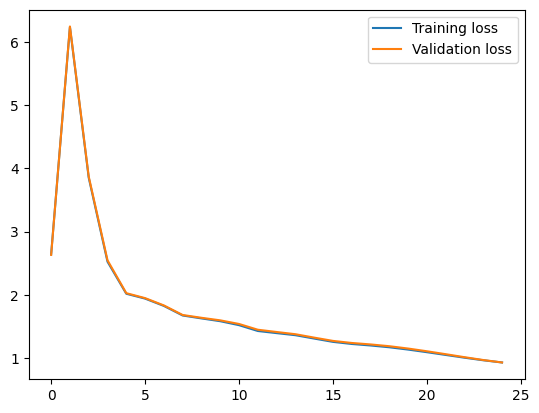

In [73]:
# plotting the training and validation loss
plt.plot([loss.detach().numpy() for loss in train_losses], label='Training loss')
plt.plot([loss.detach().numpy() for loss in val_losses], label='Validation loss')
plt.legend()
plt.show()

In [74]:
# prediction for training set
with torch.no_grad():
    train_x = train_x.float()
    output = model(train_x)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

0.6885370370370371

In [75]:
# prediction for validation set
with torch.no_grad():
    val_x = val_x.float()
    output = model(val_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)

0.6918333333333333

In [76]:
testX.shape

(10000, 28, 28)

In [77]:
test_x = testX.reshape(10000, 1, 28, 28)
test_x  = torch.from_numpy(test_x)
test_x.shape

torch.Size([10000, 1, 28, 28])

In [78]:
# generating predictions for test set
with torch.no_grad():
    test_x = test_x.float()
    output = model(test_x)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

In [79]:
test_y = testY.astype(int);
test_y = torch.from_numpy(test_y)

In [80]:
accuracy_score(test_y, predictions)

0.6787